## Importaciones

Todas las importaciones necesarias para poder correr el proyecto,
ademas de seguir las idicaciones del archivo readme.md

In [1]:
import os
import shutil
import re
import os
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import spacy
import snowballstemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import jaccard_score
from collections import defaultdict
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from scipy.sparse import csr_matrix

### 1. Transforamcion archivos a extension .txt

Primero vamos a transformar todos nuestros archivos con la extension .txt para poder manipularlos

In [2]:
# Ruta carpeta training
src_folder = 'reuters/training'
# Ruta nueva carpeta
dest_folder = 'reuters/training_txt'

# crear carpeta
os.makedirs(dest_folder, exist_ok=True)

# Iteramos sobre cada archivo para cambiar la extension
for filename in os.listdir(src_folder):
    src_file_path = os.path.join(src_folder, filename)
    dest_file_path = os.path.join(dest_folder, f"{filename}.txt")
    shutil.copy(src_file_path, dest_file_path)
print("Fixed file format")

Fixed file format


### 2. Eliminacion de stop words

Ahora vamos a eliminar las stop words de nuestra archivo stopwords.txt ya con la extension correcta

In [3]:
# Cargamos el archivo con las stop words
stop_words_file = 'reuters/stopwords.txt'
with open(stop_words_file, 'r', encoding='utf-8') as file:
    stop_words = set(file.read().split())

# Nueva carpeta con los archivos eliminados las stop words
src_folder = 'reuters/training_txt'
dest_folder = 'reuters/training_stop_words_txt'

# Crea la carpeta si no existe
os.makedirs(dest_folder, exist_ok=True)

# Funcion para leer cada archivo
def read_file_with_encodings(file_path):
    encodings = ['utf-8', 'latin-1', 'iso-8859-1']
    for encoding in encodings:
            with open(file_path, 'r', encoding=encoding) as file:
                return file.read()

for filename in os.listdir(src_folder):
    src_file_path = os.path.join(src_folder, filename)
    content = read_file_with_encodings(src_file_path).lower()
    # Removemos las stop words
    cleaned_content = ' '.join([word for word in content.split() if word not in stop_words])
    dest_file_path = os.path.join(dest_folder, filename)
    with open(dest_file_path, 'w', encoding='utf-8') as file:
        file.write(cleaned_content)
        
print("Stop words removal and file saving completed.")

Stop words removal and file saving completed.


### 3. El siguiente paso es eliminar los caracteres especiales

In [4]:
# El directorio final
input_directory = 'reuters/training_stop_words_txt'
output_directory = 'reuters/final_txt'

# Lo creamos si no existe
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Funcion para limpiar caracteres especiales
def clean_text(text):
    cleaned_text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    return cleaned_text

for filename in os.listdir(input_directory):
    with open(os.path.join(input_directory, filename), 'r', encoding='utf-8') as file:
        content = file.read()
        cleaned_content = clean_text(content)

    with open(os.path.join(output_directory, filename), 'w', encoding='utf-8') as output_file:
        output_file.write(cleaned_content)

print("All files have been processed and cleaned.")

All files have been processed and cleaned.


### 4. Stematizar y lematizar 

Vamos a stematizar y a lematizar nuestros archivos ya limpios para poder tener nuestras palabras en forma base

In [5]:
# Cargar el modelo de lenguaje de spaCy
nlp = spacy.load('en_core_web_sm')

# Inicializar el stemmer
stemmer = snowballstemmer.stemmer('english')

In [6]:
# Función para lematizar y stematizar texto
def preprocess_text(text):
    doc = nlp(text)
    stemmed_tokens = [stemmer.stemWord(token.text) for token in doc]
    lemmatized_tokens = [token.lemma_ for token in doc]
    return ' '.join(stemmed_tokens), ' '.join(lemmatized_tokens)

In [7]:
# Directorios de entrada y salida
input_dir = 'reuters/final_txt'
output_dir_stemmed = 'final/Stemmed'
output_dir_lemmatized = 'final/lemmatized'

# Crear directorios de salida si no existen
os.makedirs(output_dir_stemmed, exist_ok=True)
os.makedirs(output_dir_lemmatized, exist_ok=True)

for filename in os.listdir(input_dir):
    with open(os.path.join(input_dir, filename), 'r', encoding='utf-8') as file:
        text = file.read()
        stemmed_text, lemmatized_text = preprocess_text(text)
    
    # Guardar texto stematizado
    with open(os.path.join(output_dir_stemmed, filename), 'w', encoding='utf-8') as file:
        file.write(stemmed_text)
    
    # Guardar texto lematizado
    with open(os.path.join(output_dir_lemmatized, filename), 'w', encoding='utf-8') as file:
        file.write(lemmatized_text)

print("Procesamiento completado.")


Procesamiento completado.


## 5. Leer archivos limpios

Ahora que ya tenemos las dos carpetas limpias vamos a leer cada una y guardar para poder hacer BoW y TF-IDF

### 5.1 Carpeta de Lemmatized

In [8]:
# Directorio de la carpeta que contiene los archivos .txt
src_folder = 'final/lemmatized'

# Función para leer archivos con diferentes codificaciones
def read_file_with_encodings(file_path):
    encodings = ['utf-8', 'latin-1', 'iso-8859-1']
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as file:
                return file.read()
        except:
            continue
    raise ValueError(f"Unable to read the file {file_path} with available encodings.")

# Leer todos los archivos .txt en la carpeta
documents_lemmatized = []
filenames_lemmatized = []
for filename in os.listdir(src_folder):
    file_path = os.path.join(src_folder, filename)
    content = read_file_with_encodings(file_path)
    documents_lemmatized.append(content)
    filenames_lemmatized.append(filename)

# Verificar que se hayan leído los archivos
print(f"Archivos leídos: {len(documents_lemmatized)}")


Archivos leídos: 7769


### 5.2 Carpeta de Stemmed

In [9]:
# Directorio de la carpeta que contiene los archivos .txt
src_folder = 'final/Stemmed'

# Función para leer archivos con diferentes codificaciones
def read_file_with_encodings(file_path):
    encodings = ['utf-8', 'latin-1', 'iso-8859-1']
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as file:
                return file.read()
        except:
            continue
    raise ValueError(f"Unable to read the file {file_path} with available encodings.")

# Leer todos los archivos .txt en la carpeta
documents_stemmed = []
filenames_stemmed = []
for filename in os.listdir(src_folder):
    if filename.endswith('.txt'):
        file_path = os.path.join(src_folder, filename)
        content = read_file_with_encodings(file_path)
        documents_stemmed.append(content)
        filenames_stemmed.append(filename)

# Verificar que se hayan leído los archivos
print(f"Archivos leídos: {len(documents_stemmed)}")


Archivos leídos: 7769


## 6.Vectorización utilizando Bag of Words

In [10]:
# Función para vectorizar textos utilizando Bag of Words
def Bag_of_Words(texts):
    # Vectorización usando Bag of Words
    vectorizer = CountVectorizer()
    X_bow = vectorizer.fit_transform(texts)

    return X_bow, vectorizer

### 6.1 Utilizando la carpeta Lemmatized

In [11]:
# Vectorizar los documentos
X_bow_lemmatized, bow_vectorizer_lemmatized = Bag_of_Words(documents_lemmatized)

# Ver los resultados de Bag of Words
print("Bag of Words (BoW) Lemmatized:")
print(X_bow_lemmatized.toarray())
print("Caracteristicas de BoW Lemmatized:", bow_vectorizer_lemmatized.get_feature_names_out())

Bag of Words (BoW) Lemmatized:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Caracteristicas de BoW Lemmatized: ['000' '0006913' '0006916' ... 'zuyuan' 'zverev' 'zzzz']


### 6.2 Utilizando la carpeta Stemmed

In [12]:
# Vectorizar los documentos
X_bow_stemmed, bow_vectorizer_stemmed = Bag_of_Words(documents_stemmed)

# Ver los resultados de Bag of Words
print("Bag of Words (BoW) Stemmed:")
print(X_bow_stemmed.toarray())
print("Caracteristicas de BoW Stemmed:", bow_vectorizer_stemmed.get_feature_names_out())

Bag of Words (BoW) Stemmed:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Caracteristicas de BoW Stemmed: ['000' '0006913' '0006916' ... 'zuyuan' 'zverev' 'zzzz']


## 7.Vectorización utilizando TF-IDF

In [13]:
# Función para vectorizar textos utilizando TF-IDF
def TF_IDF(texts):
    # Vectorización usando TF-IDF
    tfidf_vectorizer = TfidfVectorizer()
    X_tfidf = tfidf_vectorizer.fit_transform(texts)
    
    return X_tfidf, tfidf_vectorizer

### 7.1 Utilizando la carpeta Lemmatized

In [14]:
# Vectorizar los documentos
X_tfidf_lemmatized, tfidf_vectorizer_lemmatized = TF_IDF(documents_lemmatized)

# Ver los resultados de TF-IDF
print("TF-IDF Lemmatized:")
print(X_tfidf_lemmatized.toarray())
print("Caracteristicas de TF-IDF Lemmatized:", tfidf_vectorizer_lemmatized.get_feature_names_out())

TF-IDF Lemmatized:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Caracteristicas de TF-IDF Lemmatized: ['000' '0006913' '0006916' ... 'zuyuan' 'zverev' 'zzzz']


### 7.1 Utilizando la carpeta Stemmed

In [15]:
# Vectorizar los documentos
X_tfidf_Stemmed, tfidf_vectorizer_Stemmed = TF_IDF(documents_stemmed)

# Ver los resultados de TF-IDF
print("TF-IDF Stemmed:")
print(X_tfidf_Stemmed.toarray())
print("Caracteristicas de TF-IDF Stemmed:", tfidf_vectorizer_Stemmed.get_feature_names_out())

TF-IDF Stemmed:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Caracteristicas de TF-IDF Stemmed: ['000' '0006913' '0006916' ... 'zuyuan' 'zverev' 'zzzz']


## 8. Query

Vamos a ingresar una query, vamos a procesar y limpiarla

In [16]:
query = "BAHIA COCOA REVIEW Showers continued throughout the week in the Bahia cocoa zone, alleviating the drought since early January and improving prospects for the coming temporao, although normal humidity levels have not been restored, Comissaria Smith said in its weekly review. The dry period means the temporao will be late this year. Arrivals for the week ended February 22 were 155,221 bags of 60 kilos making a cumulative total for the season of 5.93 mln against 5.81 at the same stage last year. Again it seems that cocoa delivered earlier on consignment was included in the"

## 8.1 Limpieza del query

In [17]:
def clean_query(query):
    # Limpiamos la query
    stop_words_file = 'reuters/stopwords.txt'
    with open(stop_words_file, 'r', encoding='utf-8') as file:
        stop_words = set(file.read().split())

    cleaned_query = ' '.join([word for word in query.split() if word.lower() not in stop_words])
    cleaned_query = re.sub(r'[^A-Za-z0-9\s]', '', cleaned_query)
    return cleaned_query

In [18]:
cleaned_query = clean_query(query)
# lematizamos y stematizamos la query
stemmed_query, lemmatized_query = preprocess_text(cleaned_query)

# 9. Método para obtener los documentos con mayor similitud

In [19]:
def top_n_documents(scores, n, filenames):

    # Asegurarse de que los puntajes sean un array 1D
    scores = scores.flatten()

    # Obtener los índices de los n puntajes más altos
    top_indices = np.argsort(scores)[-n:][::-1]

    # Obtener los textos correspondientes a esos índices

    top_texts = []
    top_titles = []

    for idx in top_indices:
        file = os.path.join(src_folder, filenames[idx])
        top_titles.append(filenames[idx])
        top_texts.append(read_file_with_encodings(file))

    top_scores = scores[top_indices]

    # Imprimir los 10 textos con mayor similitud y sus puntajes
    for i, (text, title, score) in enumerate(zip(top_texts, top_titles, top_scores), 1):

        print(f"Top {i}: {title} - Similitud: {score:.4f}")
        print(text)
        print()


# 10. Similitud Jaccard con Bag of Words aplicando stemmed y lemmatized

In [20]:
def jaccard_score(query_vector, corpus_matrix):

    query_vector = csr_matrix(query_vector)
    intersection = query_vector.minimum(corpus_matrix).sum(axis=1)
    union = query_vector.maximum(corpus_matrix).sum(axis=1)
    jaccard_scores = intersection / union
    
    return jaccard_scores.A1  # Convertir a matriz densa y luego a un array 1D


## 10.1 Lemmatized

In [21]:
# Vectorizar consulta con BoW

query_bow_lemmatized = bow_vectorizer_lemmatized.transform([lemmatized_query])

In [22]:
jaccard_scores_lemmatized = jaccard_score(query_bow_lemmatized.toarray()[0], X_bow_lemmatized.toarray())

top_n_documents(jaccard_scores_lemmatized, 5, filenames_lemmatized)


Top 1: 1.txt - Similitud: 0.1834
bahia cocoa review shower continu week bahia cocoa zone allevi drought earli januari improv prospect come temporao normal humid level restor comissaria smith week review dri period mean temporao late year arriv week end februari 22 155221 bag 60 kilo make cumul total season 593 mln 581 stage year cocoa deliv earlier consign includ arriv figur comissaria smith doubt crop cocoa harvest practic end total bahia crop estim 64 mln bag sale stand 62 mln hundr thousand bag hand farmer middlemen export processor doubt cocoa fit export shipper experienc dificulti obtain bahia superior certif view lower qualiti recent week farmer sold good part cocoa held consign comissaria smith spot bean price rose 340 350 cruzado arroba 15 kilo bean shipper reluct offer nearbi shipment limit sale book march shipment 1750 1780 dlrs tonn port name crop sale light open port junejuli 1850 1880 dlrs 35 45 dlrs york juli augsept 1870 1875 1880 dlrs tonn fob routin sale butter made ma

## 10.2 Stemmed

In [23]:
# Vectorizar consulta con BoW

print(stemmed_query)

query_bow_stemmed = bow_vectorizer_stemmed.transform([stemmed_query])

BAHIA COCOA REVIEW Shower continu week Bahia cocoa zone allevi drought earli Januari improv prospect come temporao normal humid level restor Comissaria Smith week review dri period mean temporao late year Arrival week end Februari 22 155221 bag 60 kilo make cumul total season 593 mln 581 stage year cocoa deliv earlier consign includ


In [24]:
jaccard_scores_stemmed = jaccard_score(query_bow_stemmed.toarray()[0], X_bow_stemmed.toarray())

top_n_documents(jaccard_scores_stemmed, 5, filenames_stemmed)

Top 1: 1.txt - Similitud: 0.1840
bahia cocoa review shower continu week bahia cocoa zone allevi drought earli januari improv prospect come temporao normal humid level restor comissaria smith week review dri period mean temporao late year arriv week end februari 22 155221 bag 60 kilo make cumul total season 593 mln 581 stage year cocoa deliv earlier consign includ arriv figur comissaria smith doubt crop cocoa harvest practic end total bahia crop estim 64 mln bag sale stand 62 mln hundr thousand bag hand farmer middlemen export processor doubt cocoa fit export shipper experienc dificulti obtain bahia superior certif view lower qualiti recent week farmer sold good part cocoa held consign comissaria smith spot bean price rose 340 350 cruzado arroba 15 kilo bean shipper reluct offer nearbi shipment limit sale book march shipment 1750 1780 dlrs tonn port name crop sale light open port junejuli 1850 1880 dlrs 35 45 dlrs york juli augsept 1870 1875 1880 dlrs tonn fob routin sale butter made ma

# 11. Distancia coseno con TF-IDF aplicando stemmed y lemmatized

## 11.1 Lemmatized

In [25]:
# Vectorizar Query usando tdidf lemmatized

query_tfidf_lemmatized = tfidf_vectorizer_lemmatized.transform([lemmatized_query])

In [26]:
cosine_scores_lemmatized = cosine_similarity(query_tfidf_lemmatized, X_tfidf_lemmatized)

top_n_documents(cosine_scores_lemmatized, 5, filenames_lemmatized)

Top 1: 1.txt - Similitud: 0.5293
bahia cocoa review shower continu week bahia cocoa zone allevi drought earli januari improv prospect come temporao normal humid level restor comissaria smith week review dri period mean temporao late year arriv week end februari 22 155221 bag 60 kilo make cumul total season 593 mln 581 stage year cocoa deliv earlier consign includ arriv figur comissaria smith doubt crop cocoa harvest practic end total bahia crop estim 64 mln bag sale stand 62 mln hundr thousand bag hand farmer middlemen export processor doubt cocoa fit export shipper experienc dificulti obtain bahia superior certif view lower qualiti recent week farmer sold good part cocoa held consign comissaria smith spot bean price rose 340 350 cruzado arroba 15 kilo bean shipper reluct offer nearbi shipment limit sale book march shipment 1750 1780 dlrs tonn port name crop sale light open port junejuli 1850 1880 dlrs 35 45 dlrs york juli augsept 1870 1875 1880 dlrs tonn fob routin sale butter made ma

## 11.2 Stemmed

In [27]:
# Vectorizar Query usando tdidf stemmed

query_tfidf_stemmed = tfidf_vectorizer_Stemmed.transform([stemmed_query])


In [28]:
cosine_scores_stemmed = cosine_similarity(query_tfidf_stemmed, X_tfidf_Stemmed)

top_n_documents(cosine_scores_stemmed, 5, filenames_stemmed)

Top 1: 1.txt - Similitud: 0.5400
bahia cocoa review shower continu week bahia cocoa zone allevi drought earli januari improv prospect come temporao normal humid level restor comissaria smith week review dri period mean temporao late year arriv week end februari 22 155221 bag 60 kilo make cumul total season 593 mln 581 stage year cocoa deliv earlier consign includ arriv figur comissaria smith doubt crop cocoa harvest practic end total bahia crop estim 64 mln bag sale stand 62 mln hundr thousand bag hand farmer middlemen export processor doubt cocoa fit export shipper experienc dificulti obtain bahia superior certif view lower qualiti recent week farmer sold good part cocoa held consign comissaria smith spot bean price rose 340 350 cruzado arroba 15 kilo bean shipper reluct offer nearbi shipment limit sale book march shipment 1750 1780 dlrs tonn port name crop sale light open port junejuli 1850 1880 dlrs 35 45 dlrs york juli augsept 1870 1875 1880 dlrs tonn fob routin sale butter made ma

# 12.Evaluation

### Leer cats.txt

In [29]:
# Read the categories file
categories_file = 'reuters/cats.txt'
doc_categories = {}

with open(categories_file, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split()
        filename = parts[0].split('/')[-1]  # Extraer solo el nombre del archivo
        category_type = parts[0].split('/')[0]  # Obtener si es training o test
        categories = parts[1:]
        
        if category_type == 'training':
            doc_categories[filename] = categories


In [30]:
ground_truth = defaultdict(list)

for filename, categories in doc_categories.items():
    for category in categories:
        ground_truth[category].append(filename)

In [31]:
def calculate_confusion_matrix(ground_truth, category_vectorizer, X_corpus_vectorized, similarity_method='cosine_similarity', threshold=0.0):
    confusion_matrices = []
    precisiones = []
    recalls = []

    for cat in list(ground_truth.keys()):
        true_positives = 0
        false_positives = 0
        false_negatives = 0
        true_negatives = 0
        n_cat = 0
        cat_vector = category_vectorizer.transform([cat])
        
        if similarity_method == 'cosine_similarity':
            scores = cosine_similarity(cat_vector, X_corpus_vectorized)[0]
        elif similarity_method == 'jaccard_similarity':
            scores = jaccard_score(cat_vector.toarray()[0], X_corpus_vectorized.toarray())
        else:
            raise ValueError("Método de similitud no válido. Use 'cosine_similarity' o 'jaccard_similarity'.")

        for idx, score in enumerate(scores):
            filenumber = int(filenames_lemmatized[idx].split('.')[0])
            if score > threshold:
                if filenumber in [int(file) for file in ground_truth[cat]]:
                    true_positives += 1
                    n_cat += 1
                else:
                    false_positives += 1
            else:
                if filenumber in [int(file) for file in ground_truth[cat]]:
                    false_negatives += 1
                else:
                    true_negatives += 1

        # Calcular precisión y recall
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

        # Crear la matriz de confusión y añadirla a la lista
        cm = np.array([
            [true_positives, false_positives],
            [false_negatives, true_negatives]
        ])
        confusion_matrices.append(cm)

        precisiones.append(precision)
        recalls.append(recall)

        print("---------------------------------")
        print("Categoria: ", cat)
        print("Precision: ", precision)
        print("Recall: ", recall)
        print("---------------------------------")


    # Combinar todas las matrices de confusión en una matriz general
    combined_cm = np.sum(confusion_matrices, axis=0)

    print("Matriz de confusión general: ")
    print(combined_cm)

    # Graficar la matriz de confusión general
    plt.figure(figsize=(8, 6))
    plt.imshow(combined_cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusión General')
    plt.colorbar()

    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Predicho Positivo', 'Predicho Negativo'], rotation=45)
    plt.yticks(tick_marks, ['Actual Positivo', 'Actual Negativo'])

    thresh = combined_cm.max() / 2.
    for i, j in itertools.product(range(combined_cm.shape[0]), range(combined_cm.shape[1])):
        plt.text(j, i, format(combined_cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if combined_cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')

    plt.show()

    print("Precision del sistema: ", np.mean(precisiones))
    print("Recall del sistema: ", np.mean(recalls))

    return combined_cm, np.mean(precisiones), np.mean(recalls)


## 12.1 Jaccard Lemmatized

---------------------------------
Categoria:  cocoa
Precision:  0.8983050847457628
Recall:  0.9636363636363636
---------------------------------
---------------------------------
Categoria:  sorghum
Precision:  0.8148148148148148
Recall:  0.9166666666666666
---------------------------------
---------------------------------
Categoria:  oat
Precision:  0.7142857142857143
Recall:  0.625
---------------------------------
---------------------------------
Categoria:  barley
Precision:  0.7115384615384616
Recall:  1.0
---------------------------------
---------------------------------
Categoria:  corn
Precision:  0.7810650887573964
Recall:  0.7292817679558011
---------------------------------
---------------------------------
Categoria:  wheat
Precision:  0.8423236514522822
Recall:  0.9575471698113207
---------------------------------
---------------------------------
Categoria:  grain
Precision:  0.8461538461538461
Recall:  0.45727482678983833
---------------------------------
------------

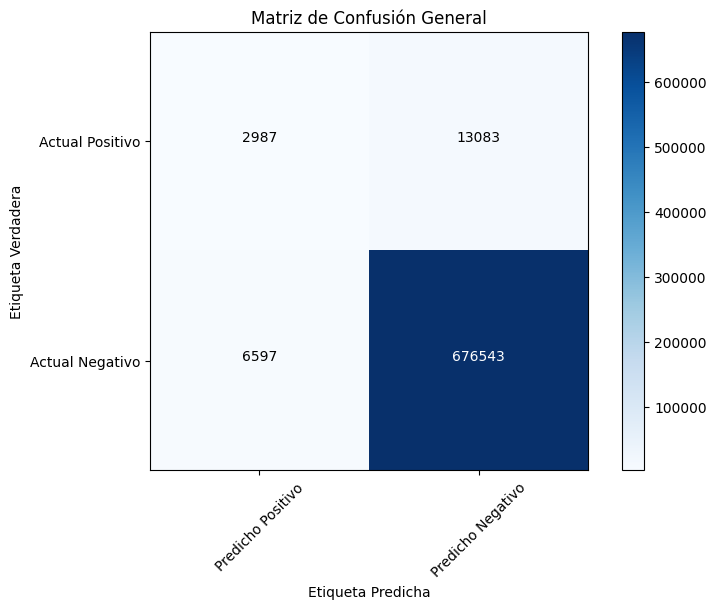

Precision del sistema:  0.3282360013330195
Recall del sistema:  0.6249198600790823


In [32]:
# Llama a la función para calcular la matriz de confusión usando similitud de Jaccard y umbral 0
combined_cm, average_precision, average_recall = calculate_confusion_matrix(
    ground_truth, bow_vectorizer_lemmatized, X_bow_lemmatized, similarity_method='jaccard_similarity', threshold=0)


## 12.2 Jaccard Stemmed

---------------------------------
Categoria:  cocoa
Precision:  0.8983050847457628
Recall:  0.9636363636363636
---------------------------------
---------------------------------
Categoria:  sorghum
Precision:  0.8148148148148148
Recall:  0.9166666666666666
---------------------------------
---------------------------------
Categoria:  oat
Precision:  0.5
Recall:  0.875
---------------------------------
---------------------------------
Categoria:  barley
Precision:  0.7115384615384616
Recall:  1.0
---------------------------------
---------------------------------
Categoria:  corn
Precision:  0.7810650887573964
Recall:  0.7292817679558011
---------------------------------
---------------------------------
Categoria:  wheat
Precision:  0.8423236514522822
Recall:  0.9575471698113207
---------------------------------
---------------------------------
Categoria:  grain
Precision:  0.8468085106382979
Recall:  0.45958429561200925
---------------------------------
---------------------------

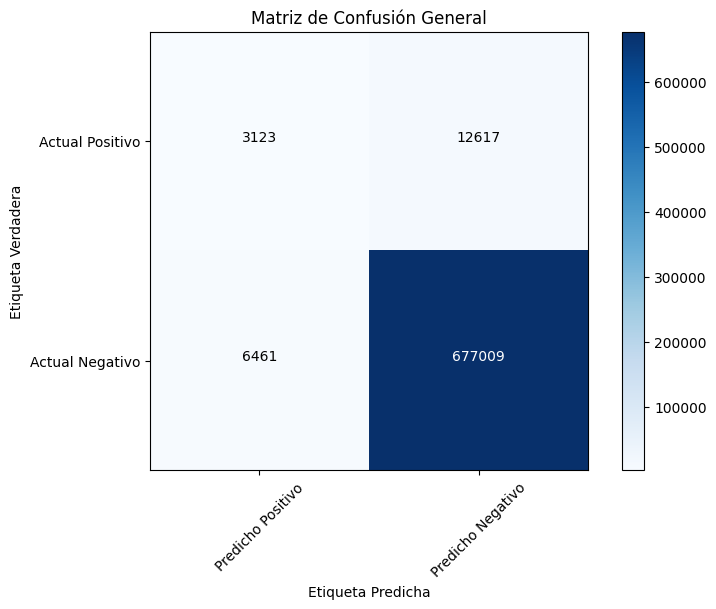

Precision del sistema:  0.2834349774495125
Recall del sistema:  0.5722688172388687


In [33]:
# Llama a la función para calcular la matriz de confusión usando similitud de Jaccard y umbral 0
combined_cm, average_precision, average_recall = calculate_confusion_matrix(
    ground_truth, bow_vectorizer_stemmed, X_bow_stemmed, similarity_method='jaccard_similarity', threshold=0)


## 12.3 Cosine Lemmatized

---------------------------------
Categoria:  cocoa
Precision:  0.8983050847457628
Recall:  0.9636363636363636
---------------------------------
---------------------------------
Categoria:  sorghum
Precision:  0.8148148148148148
Recall:  0.9166666666666666
---------------------------------
---------------------------------
Categoria:  oat
Precision:  0.7142857142857143
Recall:  0.625
---------------------------------
---------------------------------
Categoria:  barley
Precision:  0.7115384615384616
Recall:  1.0
---------------------------------
---------------------------------
Categoria:  corn
Precision:  0.7810650887573964
Recall:  0.7292817679558011
---------------------------------
---------------------------------
Categoria:  wheat
Precision:  0.8423236514522822
Recall:  0.9575471698113207
---------------------------------
---------------------------------
Categoria:  grain
Precision:  0.8461538461538461
Recall:  0.45727482678983833
---------------------------------
------------

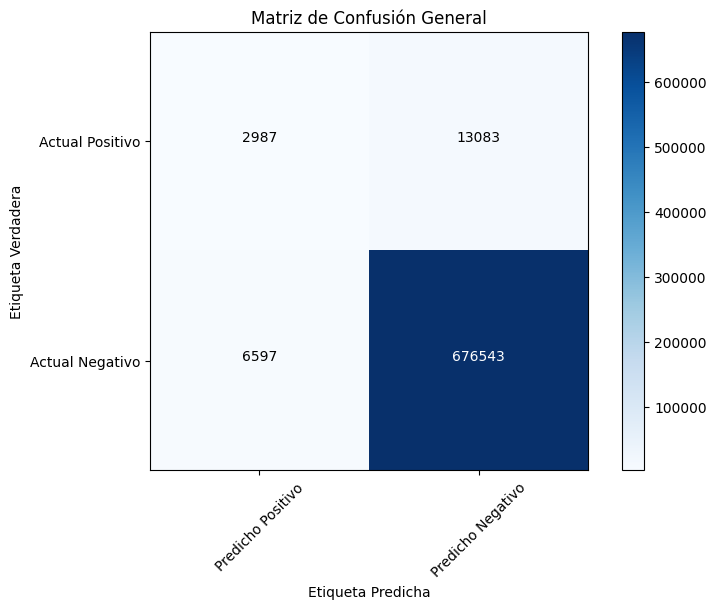

Precision del sistema:  0.3282360013330195
Recall del sistema:  0.6249198600790823


In [34]:
# Llama a la función para calcular la matriz de confusión usando similitud coseno y umbral 0.1
combined_cm, average_precision, average_recall = calculate_confusion_matrix(
    ground_truth, tfidf_vectorizer_lemmatized, X_tfidf_lemmatized, similarity_method='cosine_similarity', threshold=0)


## 12.4 Cosine Stemmed

---------------------------------
Categoria:  cocoa
Precision:  1.0
Recall:  0.2909090909090909
---------------------------------
---------------------------------
Categoria:  sorghum
Precision:  1.0
Recall:  0.041666666666666664
---------------------------------
---------------------------------
Categoria:  oat
Precision:  0.5
Recall:  0.125
---------------------------------
---------------------------------
Categoria:  barley
Precision:  1.0
Recall:  0.13513513513513514
---------------------------------
---------------------------------
Categoria:  corn
Precision:  1.0
Recall:  0.09944751381215469
---------------------------------
---------------------------------
Categoria:  wheat
Precision:  1.0
Recall:  0.0660377358490566
---------------------------------
---------------------------------
Categoria:  grain
Precision:  1.0
Recall:  0.011547344110854504
---------------------------------
---------------------------------
Categoria:  sunseed
Precision:  0
Recall:  0.0
----------------

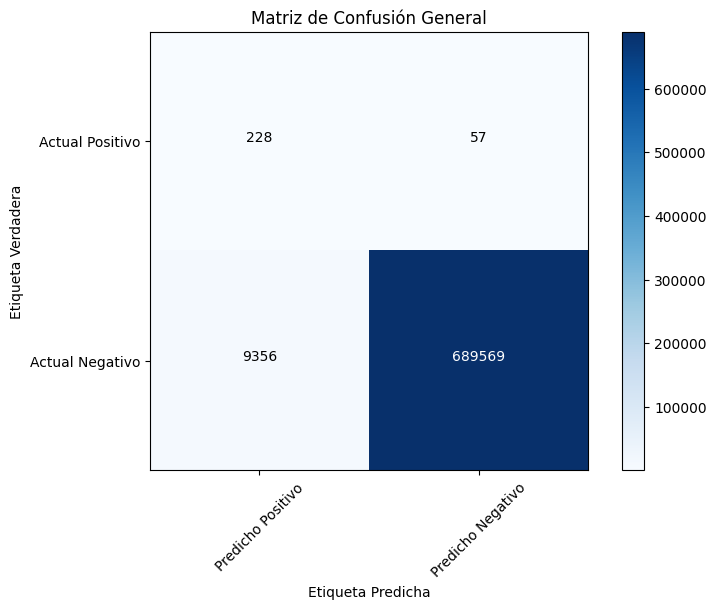

Precision del sistema:  0.3583068783068783
Recall del sistema:  0.07912183828825345


In [35]:
# Llama a la función para calcular la matriz de confusión usando similitud coseno y umbral 0.1
combined_cm, average_precision, average_recall = calculate_confusion_matrix(
    ground_truth, tfidf_vectorizer_Stemmed, X_tfidf_Stemmed, similarity_method='cosine_similarity', threshold=0.4)